In [ ]:
!pip install facenet_pytorch -q

In [1]:
from facenet_pytorch import MTCNN, InceptionResnetV1, extract_face
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler, Dataset
from sklearn.model_selection import train_test_split
from torch import optim, nn
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
import numpy as np
import os

In [2]:
from PIL import Image
import cv2
from tqdm.notebook import tqdm
from typing import Union, List, Dict, Callable, Tuple
import copy
import gc

In [3]:
from itertools import combinations, permutations, product
import pandas as pd
import random
import matplotlib.pyplot as plt
import math

In [4]:
file_path = "/kaggle/input/cropped-images/Cropped_Images"
os.chdir(file_path)

## Data Visualization

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


## Generating Triplet Pairs

In [6]:
total_count = 0
for class_name in os.listdir("../Cropped_Images/"):
    count = len(os.listdir(os.path.join("../Cropped_Images/", class_name)))
    total_count += count

comb_count = 0


for class_name in os.listdir("../Cropped_Images/"):
    count = len(os.listdir(os.path.join("../Cropped_Images/", class_name)))
    count2 = math.comb(count, 2)
    comb_count += count2
    print(f"Class: {class_name}, count: {count}, comb: {count2},"\
          f"comb_count: {comb_count}, Total Number of Expected Combinations: {comb_count * (total_count-count)}")

Class: Yisau, count: 11, comb: 55,comb_count: 55, Total Number of Expected Combinations: 16390
Class: Michael, count: 30, comb: 435,comb_count: 490, Total Number of Expected Combinations: 136710
Class: Cynthia, count: 20, comb: 190,comb_count: 680, Total Number of Expected Combinations: 196520
Class: Komolafe, count: 30, comb: 435,comb_count: 1115, Total Number of Expected Combinations: 311085
Class: Emmanuel, count: 27, comb: 351,comb_count: 1466, Total Number of Expected Combinations: 413412
Class: Ogechi, count: 22, comb: 231,comb_count: 1697, Total Number of Expected Combinations: 487039
Class: Adedayo, count: 25, comb: 300,comb_count: 1997, Total Number of Expected Combinations: 567148
Class: Jason, count: 29, comb: 406,comb_count: 2403, Total Number of Expected Combinations: 672840
Class: Mac, count: 32, comb: 496,comb_count: 2899, Total Number of Expected Combinations: 803023
Class: Nasir, count: 27, comb: 351,comb_count: 3250, Total Number of Expected Combinations: 916500
Class

In [7]:
root_dir = '../Cropped_Images'

def load_triplet_images(root_dir):
    data = []
    classlist = os.listdir(root_dir)
    for i, class_name in tqdm(enumerate(os.listdir(root_dir)), desc="PROCESSING TRIPLET PAIRS"):
        currentlist = classlist[:i] + classlist[(i+1):]
        currentImagepaths = []
        for classname in currentlist:
            imagepaths = os.listdir(os.path.join(root_dir, classname))
            random.shuffle(imagepaths)
            for imagepath in imagepaths[:10]:
                currentImagepaths.append(imagepath)

        currentpath = os.path.join(root_dir, class_name)
        neg = [imagepath for imagepath in combinations(currentImagepaths, 1)]

        imagepaths = os.listdir(currentpath)
        random.shuffle(imagepaths)
        ancpospair = [imagepath for imagepath in combinations(imagepaths[:10], 2)]
        random.shuffle(neg)
        comb = list(product(ancpospair, neg))
        comb = [(anc, pos, neg) for ((anc, pos), (neg,)) in comb]
        data.extend(comb)

    df = pd.DataFrame(data, columns=['Anchor', 'Positive','Negative'])
    return df

data = load_triplet_images(root_dir)

PROCESSING TRIPLET PAIRS: 0it [00:00, ?it/s]

In [8]:
class_map = {v: k for k, v in enumerate(os.listdir())}

In [9]:
data['Class'] = data['Anchor'].apply(lambda x: x.split('_')[0].split("'")[0]).map(class_map)
data['Anchor'] = data['Anchor'].apply(lambda x: x.split('_')[0].split("'")[0] + f"/{x}")
data['Positive'] = data['Positive'].apply(lambda x: x.split('_')[0].split("'")[0] + f"/{x}")
data['Negative'] = data['Negative'].apply(lambda x: x.split('_')[0].split("'")[0] + f"/{x}")

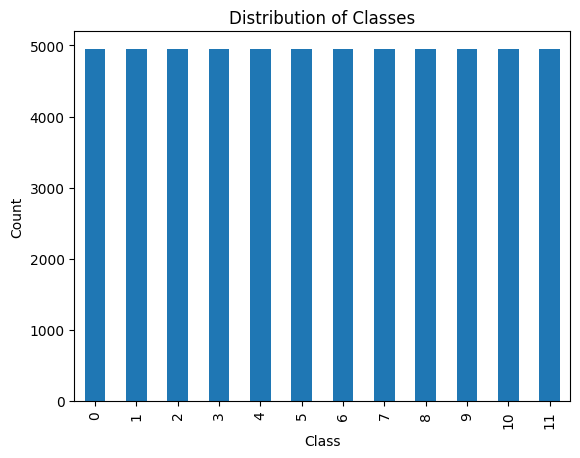

In [10]:
data['Class'].value_counts().plot(kind='bar',xlabel='Class', ylabel='Count', title='Distribution of Classes');

## Data Splitting

In [11]:
train, test = train_test_split(data, test_size=0.1, random_state=42)
train, test = train.reset_index(drop=True), test.reset_index(drop=True)

train, val = train_test_split(train, test_size=0.1, random_state=42)
train, val = train.reset_index(drop=True), val.reset_index(drop=True)
# train_paths, val_paths, train_classes, val_classes = train_test_split(file_paths, classes, test_size=0.1, stratify=classes)

## Data Loading

In [12]:
from sklearn.preprocessing import OneHotEncoder
import albumentations as A
from albumentations.pytorch import ToTensorV2

val_transform = A.Compose([
    A.HorizontalFlip(),
    ToTensorV2()
])

train_transform = A.Compose([
    A.ImageCompression(quality_lower=60, quality_upper=100, p=0.5),
    A.GaussNoise(p=0.1),
    A.GaussianBlur(blur_limit=3, p=0.05),
    A.HorizontalFlip(),
    A.OneOf([A.RandomBrightnessContrast(), A.FancyPCA(), A.HueSaturationValue()], p=0.7),
    A.ToGray(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=10, border_mode=cv2.BORDER_CONSTANT, p=0.5),
    ToTensorV2()
])

/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/blur/transforms.py:180: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(


In [13]:
ohe = OneHotEncoder(sparse_output=False)

In [14]:
class TripletFaceDataset(Dataset):
    def __init__(self, data :pd.DataFrame, transform = None):
        self.anchor = data['Anchor'].values
        self.positive = data['Positive'].values
        self.negative = data['Negative'].values
        self.transform = transform

    def __len__(self):
        return len(self.anchor)

    def __getitem__(self, idx):
        anc, pos, neg = self.anchor[idx], self.positive[idx], self.negative[idx]

        img = cv2.imread(anc)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))
        anc_image = self.transform(image=img)['image']
        anc_image = anc_image/255.0

        img = cv2.imread(pos)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))
        pos_image = self.transform(image=img)['image']
        pos_image = pos_image/255.0

        img = cv2.imread(neg)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))
        neg_image = self.transform(image=img)['image']
        neg_image = neg_image/255.0

        return (anc_image, pos_image, neg_image)


In [15]:
train_data = TripletFaceDataset(train, train_transform)
val_data = TripletFaceDataset(val, val_transform)
test_data = TripletFaceDataset(test, val_transform)

train_dl = DataLoader(train_data, batch_size=96, shuffle=True, num_workers=4)
val_dl = DataLoader(val_data, batch_size=96, shuffle=False, num_workers=4)
test_dl = DataLoader(test_data, batch_size=96, shuffle=False, num_workers=4)

In [16]:
img1, img2, img3 = next(iter(train_dl))
print(img1.shape, img2.shape, img3.shape)

torch.Size([96, 3, 224, 224]) torch.Size([96, 3, 224, 224]) torch.Size([96, 3, 224, 224])


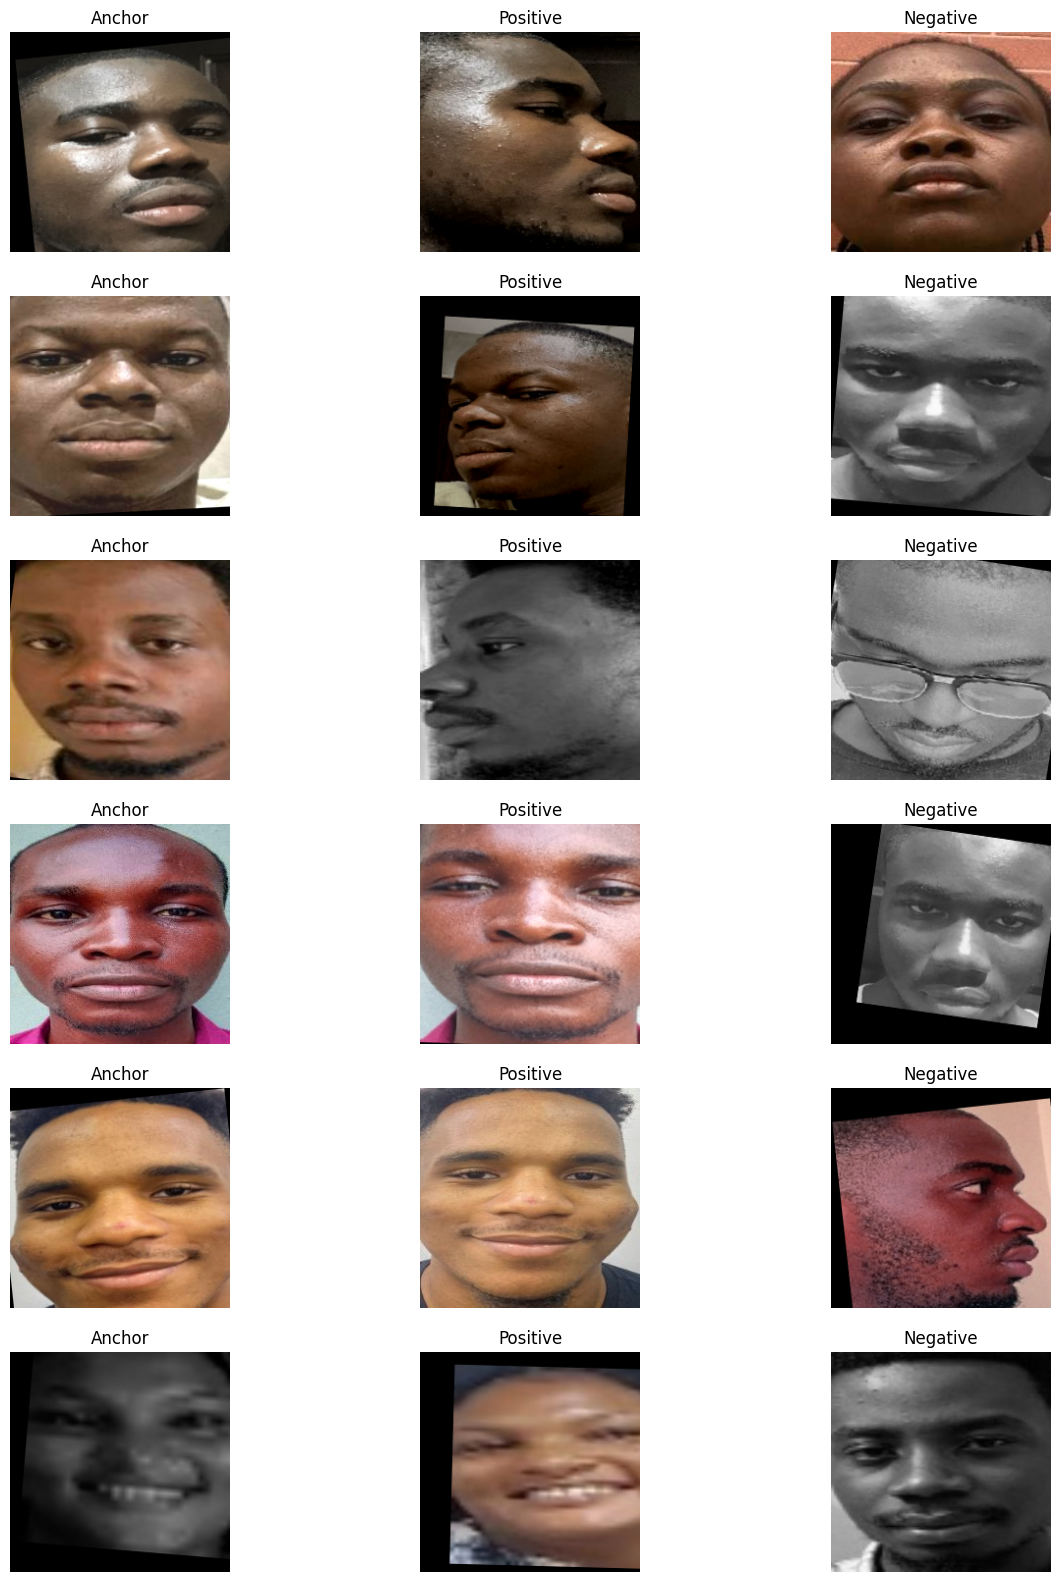

In [17]:
num_plots = 6

f, axs = plt.subplots(num_plots, 3, figsize=(15, 20))

for i in range(num_plots):
    a = img1[i]
    p = img2[i]
    n = img3[i]

    axs[i, 0].imshow(a.numpy().transpose(1,2,0))
    axs[i, 1].imshow(p.numpy().transpose(1,2,0))
    axs[i, 2].imshow(n.numpy().transpose(1,2,0))

    axs[i, 0].set_title('Anchor')
    axs[i, 1].set_title('Positive')
    axs[i, 2].set_title('Negative')

    axs[i, 0].axis('off')
    axs[i, 1].axis('off')
    axs[i, 2].axis('off')

plt.show()

## Data Modelling

In [18]:
class SiameseNetwork(torch.nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.resnet = InceptionResnetV1(pretrained='vggface2').eval()

    def forward(self, img1, img2, img3):
        # Pass each image through the Resnet
        emb_anchor = self.resnet(img1)
        emb_positive = self.resnet(img2)
        emb_negative = self.resnet(img3)
        return emb_anchor, emb_positive, emb_negative

model = SiameseNetwork().to(device)

## Training

In [19]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        pos_dist = (anchor - positive).pow(2).sum(1)  # Compute Euclidean Distance between anchor and positive
        neg_dist = (anchor - negative).pow(2).sum(1)  # Compute Euclidean Distance between anchor and negative

        loss = torch.relu(pos_dist - neg_dist + self.margin)  # Compute loss
        return loss.mean()  # Return mean loss over batch



In [20]:
def train(model: nn.Module, criterion: Callable, optimizer: optim.Optimizer, train_dl: DataLoader, epoch:int):
    model.train()
    running_loss_T = 0.0
    total_batches = len(train_dl.dataset)

    pbar = tqdm(enumerate(train_dl), total=len(train_dl), desc=f"Training Epoch {epoch+1}")
    for i, (img1, img2, img3) in pbar:
        img1, img2, img3 = img1.to(device), img2.to(device), img3.to(device)
        optimizer.zero_grad()

        emb_anchor, emb_positive, emb_negative = model(img1, img2, img3)
        loss = criterion(emb_anchor, emb_positive, emb_negative)
        loss.backward()
        optimizer.step()
        
        running_loss_T += loss.item() * img1.size(0)
        pbar.set_postfix({"loss": loss.item()})

    return running_loss_T


In [21]:
def evaluate(model: nn.Module, criterion: Callable, valid_dl: DataLoader, epoch:int):
    model.eval()
    running_loss_V = 0.0
    total_batches = len(valid_dl.dataset)

    pbar = tqdm(enumerate(valid_dl), total=len(valid_dl), desc=f"Evaluating Epoch {epoch+1}")
    with torch.no_grad():
        for i, (img1, img2, img3) in pbar:
            img1, img2, img3 = img1.to(device), img2.to(device), img3.to(device)

            emb_anchor, emb_positive, emb_negative = model(img1, img2, img3)
            loss = criterion(emb_anchor, emb_positive, emb_negative)
            running_loss_V += loss.item() * img1.size(0)
            pbar.set_postfix({"val_loss": loss.item()})
    
    return running_loss_V


In [22]:
len(train_dl) * 96, len(train_dl.dataset)

(48192, 48114)

In [23]:
def train_model(model: nn.Module, criterion: Callable, optimizer: optim.Optimizer,
                scheduler: optim.lr_scheduler, train_dl: DataLoader, val_dl: DataLoader,
                num_epochs: int = 10) -> Tuple[nn.Module, List[float], List[float]]:

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1.0
    patience = 5
    counter = 0
    train_loss = []
    valid_loss = []

    for epoch in range(num_epochs):

        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        running_loss_T = train(model, criterion, optimizer, train_dl, epoch)
        running_loss_V = evaluate(model, criterion, val_dl, epoch)

        Train_loss = running_loss_T / len(train_dl.dataset)
        train_loss.append(Train_loss)
        Valid_loss = running_loss_V / len(val_dl.dataset)
        valid_loss.append(Valid_loss)

        scheduler.step(Valid_loss)
        print(f'Train Loss: {(Train_loss):.4f} Valid Loss: {(Valid_loss):.4f}')

        if Valid_loss < best_loss:
            print(f'Val Loss decreased from {(best_loss):.4f} to {(Valid_loss):.4f}')
            best_loss = Valid_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            counter = 0

        else:
            counter += 1
            if counter >= patience:
                print("Early stopping")
                break


    print('Best loss {:.4f}'.format(best_loss))
    model.load_state_dict(best_model_wts)

    torch.cuda.empty_cache()
    gc.collect()

    return model, train_loss, valid_loss

In [24]:
criterion = TripletLoss(margin=2.0)
optimizer = optim.Adam(model.parameters(),lr=1e-4, weight_decay=1e-5)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.1,patience=3)

TRmodel, tl, vl = train_model(model, criterion, optimizer, scheduler, train_dl, val_dl, num_epochs=20)

Epoch 0/19
----------


Training Epoch 1:   0%|          | 0/502 [00:00<?, ?it/s]

Evaluating Epoch 1:   0%|          | 0/56 [00:00<?, ?it/s]

Train Loss: 0.0302 Valid Loss: 0.0002
Val Loss decreased from 1.0000 to 0.0002
Epoch 1/19
----------


Training Epoch 2:   0%|          | 0/502 [00:00<?, ?it/s]

Evaluating Epoch 2:   0%|          | 0/56 [00:00<?, ?it/s]

Train Loss: 0.0055 Valid Loss: 0.0002
Epoch 2/19
----------


Training Epoch 3:   0%|          | 0/502 [00:00<?, ?it/s]

Evaluating Epoch 3:   0%|          | 0/56 [00:00<?, ?it/s]

Train Loss: 0.0051 Valid Loss: 0.0000
Val Loss decreased from 0.0002 to 0.0000
Epoch 3/19
----------


Training Epoch 4:   0%|          | 0/502 [00:00<?, ?it/s]

Evaluating Epoch 4:   0%|          | 0/56 [00:00<?, ?it/s]

Train Loss: 0.0042 Valid Loss: 0.0000
Val Loss decreased from 0.0000 to 0.0000
Epoch 4/19
----------


Training Epoch 5:   0%|          | 0/502 [00:00<?, ?it/s]

Evaluating Epoch 5:   0%|          | 0/56 [00:00<?, ?it/s]

Train Loss: 0.0035 Valid Loss: 0.0003
Epoch 5/19
----------


Training Epoch 6:   0%|          | 0/502 [00:00<?, ?it/s]

Evaluating Epoch 6:   0%|          | 0/56 [00:00<?, ?it/s]

Train Loss: 0.0033 Valid Loss: 0.0000
Epoch 6/19
----------


Training Epoch 7:   0%|          | 0/502 [00:00<?, ?it/s]

Evaluating Epoch 7:   0%|          | 0/56 [00:00<?, ?it/s]

Train Loss: 0.0021 Valid Loss: 0.0025
Epoch 7/19
----------


Training Epoch 8:   0%|          | 0/502 [00:00<?, ?it/s]

Evaluating Epoch 8:   0%|          | 0/56 [00:00<?, ?it/s]

Train Loss: 0.0027 Valid Loss: 0.0000
Epoch 8/19
----------


Training Epoch 9:   0%|          | 0/502 [00:00<?, ?it/s]

Evaluating Epoch 9:   0%|          | 0/56 [00:00<?, ?it/s]

Train Loss: 0.0010 Valid Loss: 0.0000
Early stopping
Best loss 0.0000


In [27]:
def predict_and_evaluate(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    embeddings, labels = [], []

    with torch.no_grad():
        for anc_img, pos_img, neg_img in tqdm(data_loader, desc="Prediction.."):
            anc_img, pos_img, neg_img = anc_img.to(device), pos_img.to(device), neg_img.to(device)
            anc_emb, pos_emb, neg_emb = model(anc_img, pos_img, neg_img)
            embeddings.append((anc_emb, pos_emb, neg_emb))

            # Optionally, compute the distances for evaluation
            pos_dist = (anc_emb - pos_emb).pow(2).sum(1).sqrt()  # Distance between anchor and positive
            neg_dist = (anc_emb - neg_emb).pow(2).sum(1).sqrt()  # Distance between anchor and negative

            # You can store these distances along with some threshold to evaluate
            labels.append((pos_dist, neg_dist))

    return embeddings, labels


In [26]:
test_embeddings, test_labels = predict_and_evaluate(TRmodel, test_dl)


In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(labels):
    y_true = []
    y_scores = []
    
    # Gather labels and scores
    for pos_dist, neg_dist in labels:
        a = [[1,0] for i in range(len(pos_dist))] # 1 for positive, 0 for negative
        y_true.extend(a)  
        y_scores.append([pos_dist.cpu().numpy(), neg_dist.cpu().numpy()])
    
    # Flatten lists
    y_true = np.concatenate(y_true)
    y_scores = np.hstack(y_scores).reshape(-1)
    print(y_true.shape, y_scores.shape)
    
    # Compute ROC curve and ROC area
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


(11880,) (11880,)


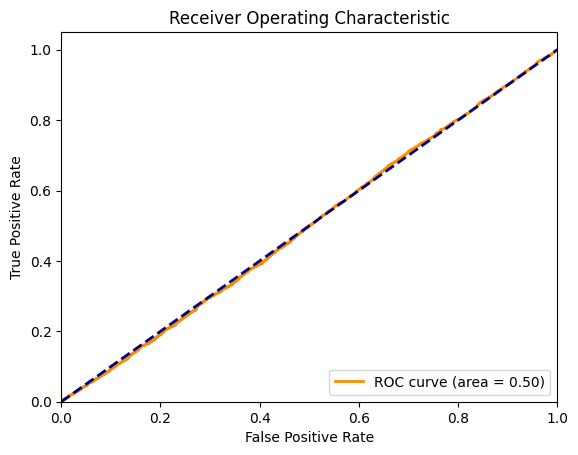

In [29]:
plot_roc_curve(test_labels)

In [30]:
def plot_distance_histograms(labels):
    positive_distances = []
    negative_distances = []
    
    for pos_dist, neg_dist in labels:
        positive_distances.append(pos_dist.cpu().numpy())
        negative_distances.append(neg_dist.cpu().numpy())
    
    # Flatten lists
    positive_distances = np.concatenate(positive_distances)
    negative_distances = np.concatenate(negative_distances)
    
    # Plot histograms
    plt.figure()
    plt.hist(positive_distances, bins=30, alpha=0.7, label='Positive Distances')
    plt.hist(negative_distances, bins=30, alpha=0.7, label='Negative Distances', color='red')
    plt.title('Histogram of Distances')
    plt.xlabel('Distance')
    plt.ylabel('Frequency')
    plt.legend(loc='upper right')
    plt.show()


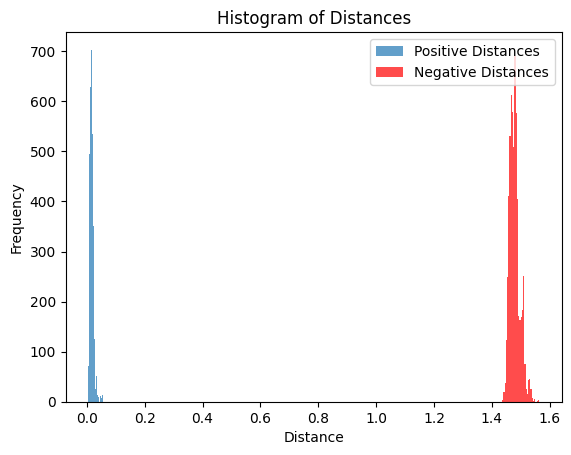

In [31]:
plot_distance_histograms(test_labels)

In [32]:
def calculate_metrics(labels, threshold):
    tp = fp = tn = fn = 0
    for pos_dist, neg_dist in labels:
        tp = np.sum(np.where(pos_dist.cpu().numpy() < threshold, 1, 0))
        fn = np.sum(np.where(pos_dist.cpu().numpy() > threshold, 1, 0))

        tn = np.sum(np.where(neg_dist.cpu().numpy() >= threshold, 1, 0))
        fp = np.sum(np.where(neg_dist.cpu().numpy() <= threshold, 1, 0))
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    return precision, recall, f1_score

calculate_metrics(test_labels, 0.50)

(1.0, 1.0, 1.0)

## Inference

In [33]:
def process_image(image_path, transform, label=None):
    """Load an image from the disk and apply transformations."""
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = transform(image=img)['image']  # Assuming you are using Albumentations for transforms
    img = img / 255.0
    if label:
        return img, label
    else:
        return img
    
def get_labels(positive_distance, negative_distance, positive_label, threshold=0.49):
    if positive_distance <= threshold and negative_distance <= threshold:
        return positive_label
    elif positive_distance <= threshold and negative_distance > threshold:
        return "Match with Positive"
    elif positive_distance > threshold and negative_distance > threshold:
        return "Unknown or No Match Found"
    elif positive_distance > threshold and negative_distance <= threshold:
        return "Match with Negative (Error Case)"
    else:
        return "Ambiguous Case"

def infer_siamese(model, anchor_path, positive_path, negative_path, transform, label):
    # Process images
    anchor_img, anchor_label = process_image(anchor_path, transform, label)
    anchor_img = anchor_img.unsqueeze(0).to(device)  # Add batch dimension
    
    positive_img, positive_label = process_image(positive_path, transform, label)
    positive_img = positive_img.unsqueeze(0).to(device)
    
    assert anchor_label == positive_label, "Anchor and Positive Image should belong to the same person."
    
    negative_img = process_image(negative_path, transform).unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        # Get embeddings
        anchor_emb, positive_emb, negative_emb = model(anchor_img, positive_img, negative_img)
        
        # Calculate distances
        positive_distance = (anchor_emb - positive_emb).pow(2).sum().sqrt().item()  # Scalar value
        negative_distance = (anchor_emb - negative_emb).pow(2).sum().sqrt().item()  # Scalar value
        
    label = get_labels(positive_distance, negative_distance, positive_label)
    return label

In [38]:
classnum = 3
a = list(data[data['Class']==classnum]['Anchor'].unique())
b = list(data[data['Class']==classnum]['Positive'].unique())
a.extend(b)
a = set(a)

def get_key(val, my_dict):
    for key, value in my_dict.items():
        if val == value:
            return key
        
classname = get_key(classnum, class_map)

In [39]:
classlist = os.listdir()

testcase = os.listdir(classname)
random.shuffle(testcase)

for imp in testcase:
    if imp not in a:
        class_diff = random.choice(classlist)
        imagepaths = os.listdir(class_diff)
        random.shuffle(imagepaths)
        ancpospair = [imagepath for imagepath in combinations(imagepaths[:5], 2)]
        anc_path = os.path.join(class_diff, random.choice(ancpospair)[0])
        pos_path = os.path.join(class_diff, random.choice(ancpospair)[1])
        
        neg_path = os.path.join(classname, imp)
        pred = infer_siamese(TRmodel, anc_path, pos_path, neg_path, val_transform, class_diff)
        print(f"ClassName: {classname}, ClassDiff: {class_diff}, PRED LABEL: {pred}")
        
        

ClassName: Komolafe, ClassDiff: Michael, PRED LABEL: Match with Positive
ClassName: Komolafe, ClassDiff: Komolafe, PRED LABEL: Komolafe
ClassName: Komolafe, ClassDiff: Cynthia, PRED LABEL: Match with Positive
ClassName: Komolafe, ClassDiff: Yisau, PRED LABEL: Match with Positive
ClassName: Komolafe, ClassDiff: Michael, PRED LABEL: Match with Positive
ClassName: Komolafe, ClassDiff: Adedayo, PRED LABEL: Match with Positive
ClassName: Komolafe, ClassDiff: Michael, PRED LABEL: Match with Positive
ClassName: Komolafe, ClassDiff: Komolafe, PRED LABEL: Komolafe
ClassName: Komolafe, ClassDiff: Yisau, PRED LABEL: Match with Positive
ClassName: Komolafe, ClassDiff: Emmanuel, PRED LABEL: Match with Positive
ClassName: Komolafe, ClassDiff: Yisau, PRED LABEL: Match with Positive
ClassName: Komolafe, ClassDiff: Michael, PRED LABEL: Match with Positive
ClassName: Komolafe, ClassDiff: Mac, PRED LABEL: Unknown or No Match Found
ClassName: Komolafe, ClassDiff: Jason, PRED LABEL: Match with Positive
Cla

In [41]:
torch.save(TRmodel.state_dict(), "/kaggle/working/InceptionResnetV1_state_dict.pth")